
프로젝트 주제 :자동차의 종에 따라 분류 및 사고의 규모를 보고 차종을 예측하는 모델 만들기

분석 기법 : 의사결정 트리, 로지스틱회귀, 선형회귀

In [227]:
# 사용할 라이브러리 불러오기
import pandas as pd
import numpy as np
#선형회귀
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
# 의사결정트리 라이브러리
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeRegressor
#로직스틱회귀
from sklearn.linear_model import LogisticRegression
import seaborn as sns
#랜덤포레스트
from sklearn.ensemble import RandomForestClassifier


In [228]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
data_set = pd.read_excel('/content/drive/MyDrive/데이터마이닝실습/데마프로젝트/Korea Road Traffic Authority_Statistics of traffic accidents 20211231.xlsx')

data_set

,Large classification of the use of the offender's vehicle,Classification of the perpetrator's vehicle use,Perpetrator vehicle use,timezone,number of accidents,number of death,number of slanderers,number of casualties,number of reported injuries
0,for business,route bus,city bus,00hour-02hour,24,0,13,15,3
1,for business,route bus,city bus,02hour-04hour,1,0,0,0,1
2,for business,route bus,city bus,04hour-06hour,41,4,16,25,2
3,for business,route bus,city bus,06hour-08hour,237,6,88,238,14
4,for business,route bus,city bus,08hour-10hour,432,3,136,435,37
...,...,...,...,...,...,...,...,...,...
302,other/unknown,other/unknown,other/unknown,14hour-16hour,205,1,28,143,46
303,other/unknown,other/unknown,other/unknown,16hour-18hour,323,1,51,211,90
304,other/unknown,other/unknown,other/unknown,18hour-20hour,542,1,62,388,136
305,other/unknown,other/unknown,other/unknown,20hour-22hour,419,0,40,341,109


1. 선형회귀 시간대에 따른 사고횟수를 선형회귀로 분석


In [230]:
print(data_set.columns) #열 확인

Index(['Large classification of the use of the offender's vehicle',
       'Classification of the perpetrator's vehicle use',
       'Perpetrator vehicle use', 'timezone', 'number of accidents',
       'number of death', 'number of slanderers', 'number of casualties',
       'number of reported injuries'],
      dtype='object')


In [231]:
# 필요한 열 선택, 시간과 사고횟수를 선택
features = data_set[['timezone', 'number of accidents']]

# 'timezone' 열을 수치형으로 변환 (예: 0, 1, 2, ...)
features['timezone'] = pd.factorize(features['timezone'])[0]

<ipython-input-231-67829f9b8f40>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['timezone'] = pd.factorize(features['timezone'])[0]


In [232]:
# 목표 변수 설정
target = features['number of accidents']

In [233]:
# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(features[['timezone']], target, test_size=0.2, random_state=42)

In [234]:
# 선형 회귀 모델 생성 및 훈련
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 테스트 데이터로 성능 평가
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f"Mean Squared Error (Linear Regression): {mse_linear}")

Mean Squared Error (Linear Regression): 6508571.475646327


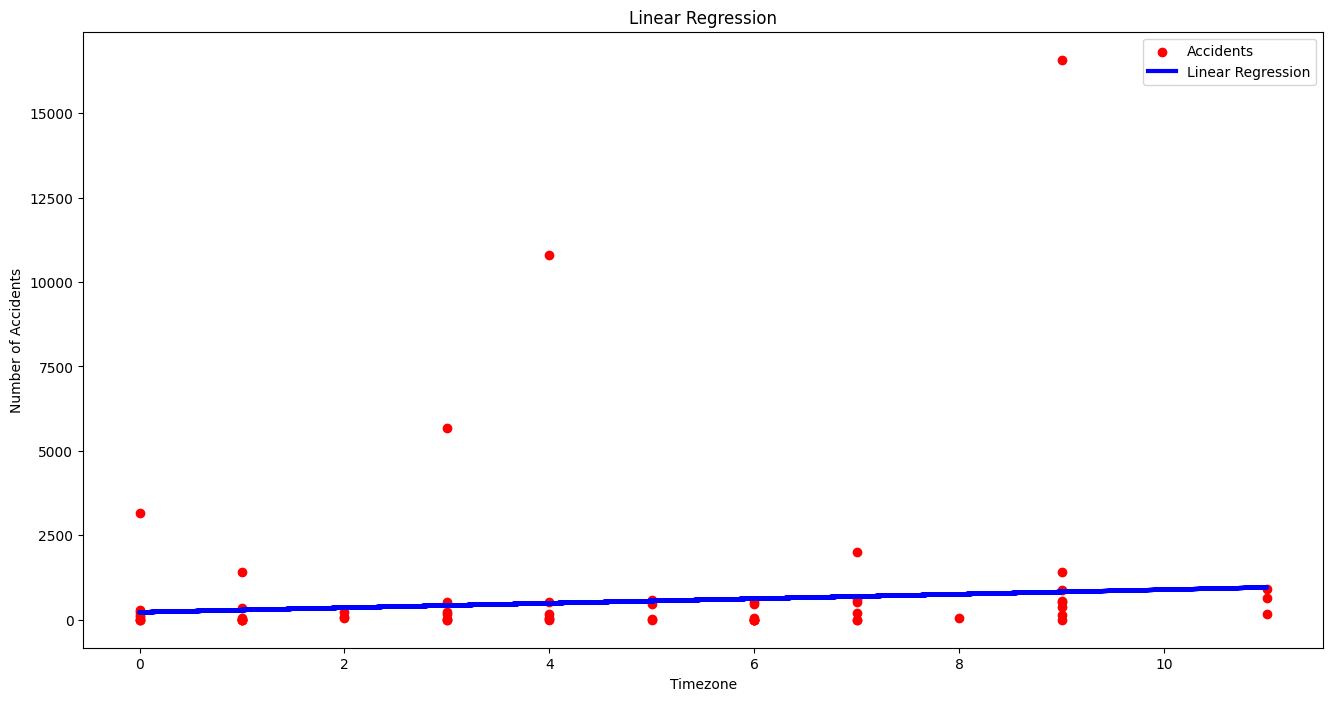

In [235]:
# 테스트 데이터와 예측 결과를 그래프로 나타내기
plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, color='red', label='Accidents')
plt.plot(X_test, y_pred_linear, color='blue', linewidth=3, label='Linear Regression')
plt.xlabel('Timezone')
plt.ylabel('Number of Accidents')
plt.title('Linear Regression')
plt.legend()
plt.show()

의사 결정트리를 이용한 시간대의 따른 사상자의 수 파악 해보기

In [236]:
# 필요한 열 선택
features = data_set[['timezone']]
target = data_set[['number of death', 'number of slanderers', 'number of casualties', 'number of reported injuries']]

In [237]:
# 'timezone' 열을 수치형으로 변환 (예: 0, 1, 2, ...)
features['timezone'] = pd.factorize(features['timezone'])[0]

<ipython-input-237-403f92a7c60d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['timezone'] = pd.factorize(features['timezone'])[0]


In [238]:
# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [239]:
# 회귀용 의사결정트리 모델 생성 및 훈련
regression_model = DecisionTreeRegressor()
regression_model.fit(X_train, y_train)

# 테스트 데이터로 성능 평가
y_pred_regression = regression_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_regression)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2280689.376849166


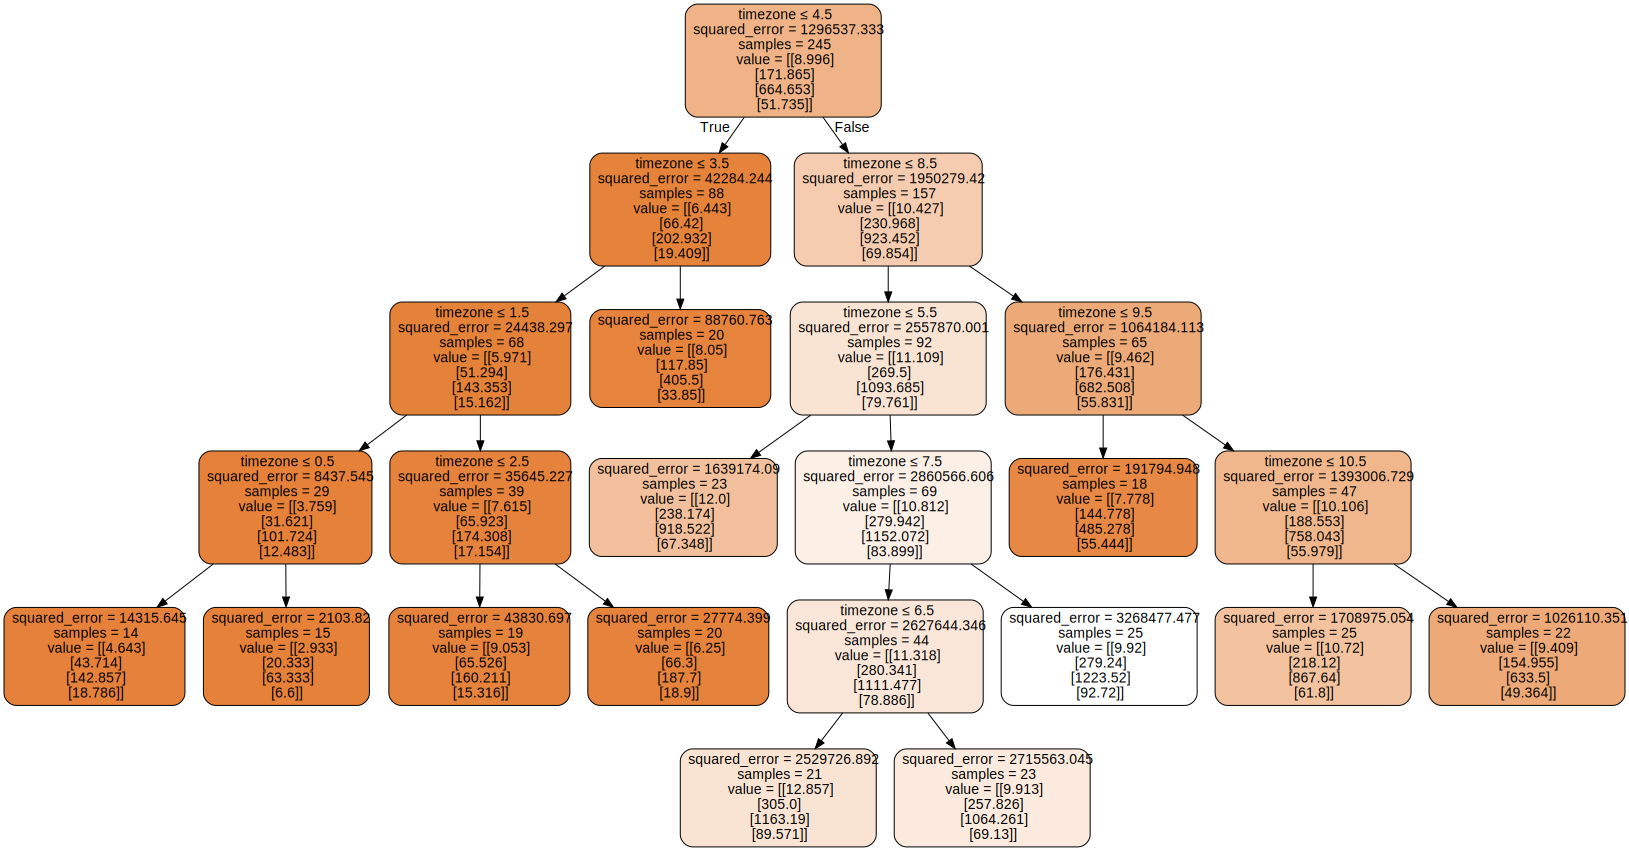

In [240]:
# 의사결정트리를 dot 형식의 텍스트로 변환
dot_data_regression = export_graphviz(regression_model, out_file=None, feature_names=features.columns, filled=True, rounded=True, special_characters=True)

# dot 형식을 그래프로 변환
graph_regression = graphviz.Source(dot_data_regression)
graph_regression

3. 로지스틱 회귀

In [241]:
# 'number of accidents'를 기반으로 다양한 규모의 사고에 대한 클래스 생성, 사고x 경미, 중형, 대형, 특대형사고
data_set['Accident_Class'] = pd.cut(data_set['number of accidents'], bins=[-1, 0, 5, 10, 100, float('inf')],
                                    labels=['No Accident', 'Small', 'Medium', 'Large', 'Very Large'])

In [242]:
# 필요한 열 선택
features = data_set[['number of death', 'number of slanderers', 'number of casualties', 'number of reported injuries']]

# 목표 변수 설정
target = data_set['Accident_Class']

In [243]:
# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 생성 및 훈련
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [244]:
 #테스트 데이터로 성능 평가
y_pred_logistic = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
print(f"Accuracy: {accuracy_logistic}")

Accuracy: 0.9516129032258065


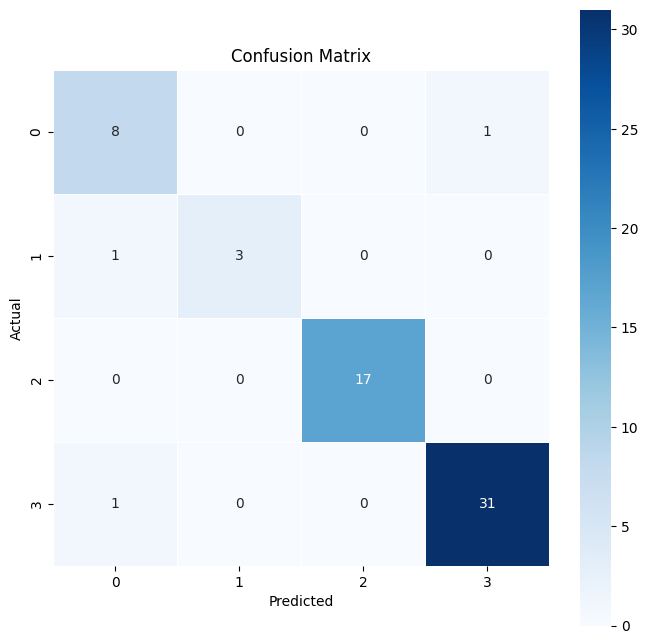

In [245]:
# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred_logistic)

# seaborn을 사용하여 시각화
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

4. 사고 발생 횟수 및 사상자 수에 따른 차종 예측

In [246]:
# 필요한 열 선택
features = data_set[['number of accidents', 'number of death', 'number of slanderers', 'number of casualties', 'number of reported injuries']]

# 목표 변수: 차종
target = data_set['Perpetrator vehicle use']

In [247]:
# 훈련 데이터와 테스트 데이터로 나누기
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 랜덤 포레스트 분류기 모델 생성 및 훈련
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [248]:
# 테스트 데이터로 성능 평가
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4032258064516129


In [249]:
# 특성 중요도 가져오기
feature_importances = rf_classifier.feature_importances_

# 특성 중요도를 내림차순으로 정렬하고 인덱스를 가져오기
indices = feature_importances.argsort()[::-1]

# 각 특성의 이름 가져오기
feature_names = features.columns

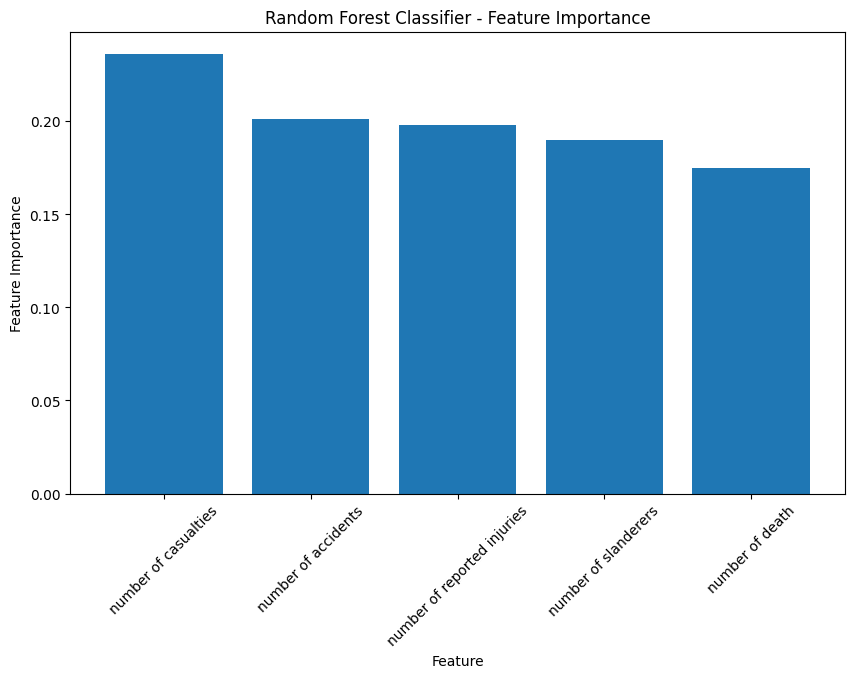

In [250]:
# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(features.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(features.shape[1]), feature_names[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()